In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder,MinMaxScaler


# Outlier Detection and Removal in the Student Dataset

## Overview

In data analysis, outliers can significantly skew the results and lead to erroneous conclusions. The code outlined here focuses on identifying and removing outliers in the `student_data` dataset. This process is essential for improving the accuracy of any subsequent statistical analysis or machine learning models.

## Identifying Numeric Columns

The first step is to isolate the numeric columns as outliers are typically a concern with quantitative data:

```python
numeric_columns = student_data.select_dtypes(include=['int64', 'float64']).columns


### Outlier Detection Using Interquartile Range (IQR)

This function calculates the first (Q1) and third (Q3) quartiles, and the IQR (Q3 - Q1). Outliers are then identified as the values that fall below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR. This method is effective for a wide range of distributions, even if they are not normally distributed.

### Summary of Outliers in Each Numeric Column

We apply the outlier detection function to each numeric column and create a summary that lists the number of outliers detected in each. This loop iterates through each numeric column, applies the outlier detection function, and stores the count of outliers in a dictionary. This summary provides a clear view of which columns contain the most significant number of outliers.

### Removing Outliers
The removal function follows the same IQR logic to define the acceptable range of values. Data points outside this range are excluded, effectively removing outliers. This loop applies the removal process to each numeric column. It's important to note that this step modifies the original dataset by excluding the outlier values.


In [3]:
student_data = pd.read_csv('student_data.csv')

student_data.dropna(inplace=True)

columns_to_convert_to_boolean = ['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']

for column in columns_to_convert_to_boolean:
    student_data[column] = student_data[column].map({'yes': True, 'no': False})


numeric_columns = student_data.select_dtypes(include=['int64', 'float64']).columns

# Function to detect outliers using IQR
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

outlier_summary = {}
for col in numeric_columns:
    outliers = detect_outliers(student_data, col)
    outlier_summary[col] = len(outliers)

outlier_summary

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

for col in numeric_columns:
    student_data = remove_outliers(student_data, col)

new_shape = student_data.shape
new_shape




(219, 33)

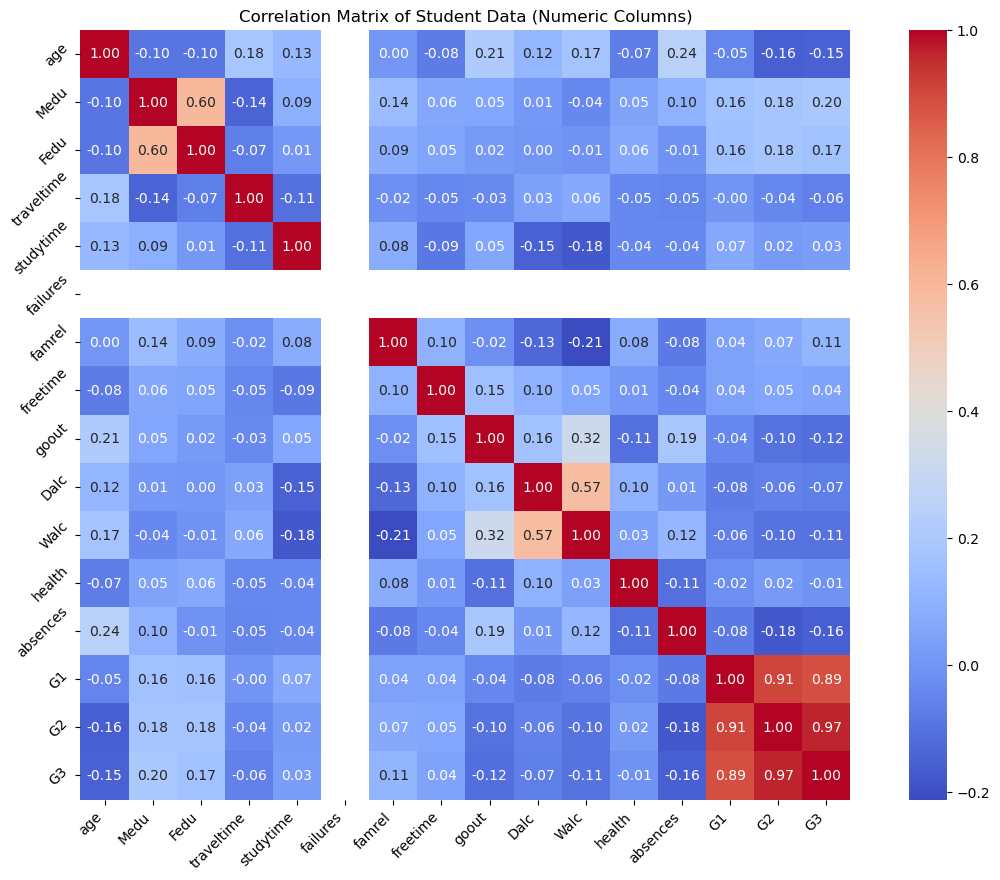

In [4]:
numeric_student_data = student_data.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(15, 10))

sns.heatmap(numeric_student_data.corr(), annot=True, fmt='.2f', cmap='coolwarm', square=True)

plt.title('Correlation Matrix of Student Data (Numeric Columns)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45)

plt.show()


In [5]:
student_data

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10
5,GP,M,16,U,LE3,T,4,3,services,other,...,5,4,2,1,2,5,10,15,15,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,MS,F,18,R,GT3,T,2,2,at_home,other,...,5,3,3,1,3,4,2,10,9,10
386,MS,F,18,R,GT3,T,4,4,teacher,at_home,...,4,4,3,2,2,5,7,6,5,6
388,MS,F,18,U,LE3,T,3,1,teacher,services,...,4,3,4,1,1,1,0,7,9,8
393,MS,M,18,R,LE3,T,3,2,services,other,...,4,4,1,3,4,5,0,11,12,10


# Trend Analysis

## Objective


Our objective is to develop a predictive model to estimate student grades based on a range of influencing factors present in the dataset. This dataset encompasses various variables, including demographic details, family background, personal habits, and academic history, which potentially impact student performance. By leveraging these attributes, we aim to predict the grades of students (G1, G2, G3) with a degree of accuracy that can aid in identifying key predictors of academic success. Such a model could be instrumental for educational institutions and policymakers in formulating strategies to enhance student outcomes. Additionally, it can provide valuable insights into the relationship between students' personal and social environments and their academic achievements. This analysis will not only contribute to a better understanding of educational dynamics but also pave the way for more personalized and effective educational support systems.

## Exploratory Data Analysis

### Dataset Overview

The info() method provides a concise summary of the DataFrame. This includes the list of all columns, their data types, and the number of non-null values in each column. It's useful for getting a quick overview of the DataFrame, ensuring that the data types are correctly interpreted, and identifying columns with missing values.

### Statistical Summary of Numerical Features

The describe() method generates descriptive statistics that summarize the central tendency, dispersion, and shape of a dataset’s distribution, excluding NaN values. It's particularly useful for understanding the distribution of numerical variables. It gives the count, mean, standard deviation, minimum, quartiles, and maximum values for each numeric column.

### Visualizing Data Distribution
#### Histograms of Numerical Variables

num_cols = student_data.select_dtypes(include=['int64', 'float64']).columns
student_data[num_cols].hist(bins=15, figsize=(15, 10), layout=(4, 4))

This section of the code identifies all numeric columns and generates histograms for each. Histograms are useful for visualizing the distribution of numerical data, allowing us to see patterns, outliers, skewness, etc. The bins parameter determines the number of bins used in the histogram, and figsize and layout control the size and layout of the plot grid.

### Count Plots of Categorical Variables

Here, categorical columns are identified, and count plots are created for each. Count plots display the counts of observations in each categorical bin using bars. This is helpful to understand the distribution of categorical variables and to identify if any categories are particularly common or rare in the dataset.

### Box Plots of Numerical Variables
Box plots for each numeric column are generated, showing the quartiles of the dataset and identifying outliers. These plots give a clear summary of the central tendency and dispersion of the data, and they are particularly useful for detecting outliers.

### Box Plot for Study Time and Final Grades

A box plot is created to visualize the relationship between students' study time and their final grades (G3). This can provide insights into whether more study time is associated with higher grades.




<class 'pandas.core.frame.DataFrame'>
Index: 219 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      219 non-null    object
 1   sex         219 non-null    object
 2   age         219 non-null    int64 
 3   address     219 non-null    object
 4   famsize     219 non-null    object
 5   Pstatus     219 non-null    object
 6   Medu        219 non-null    int64 
 7   Fedu        219 non-null    int64 
 8   Mjob        219 non-null    object
 9   Fjob        219 non-null    object
 10  reason      219 non-null    object
 11  guardian    219 non-null    object
 12  traveltime  219 non-null    int64 
 13  studytime   219 non-null    int64 
 14  failures    219 non-null    int64 
 15  schoolsup   219 non-null    bool  
 16  famsup      219 non-null    bool  
 17  paid        219 non-null    bool  
 18  activities  219 non-null    bool  
 19  nursery     219 non-null    bool  
 20  higher      219

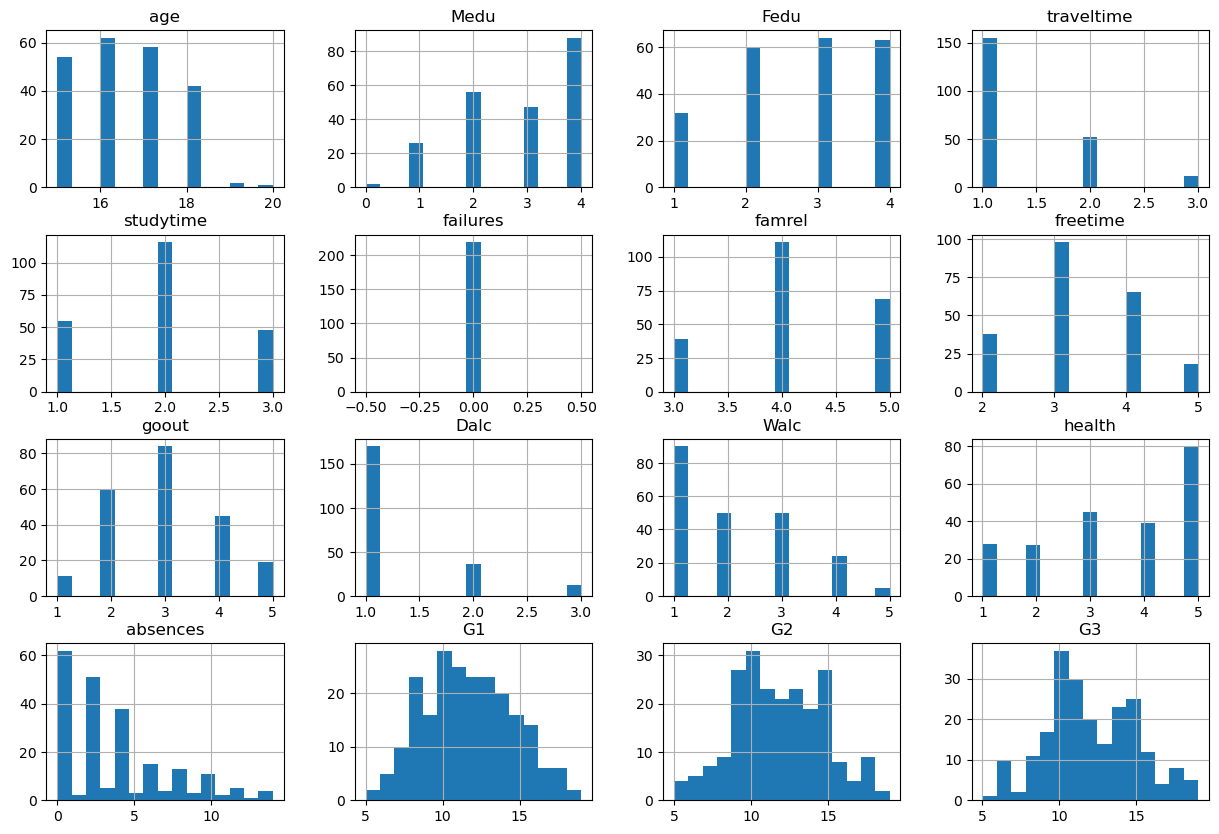

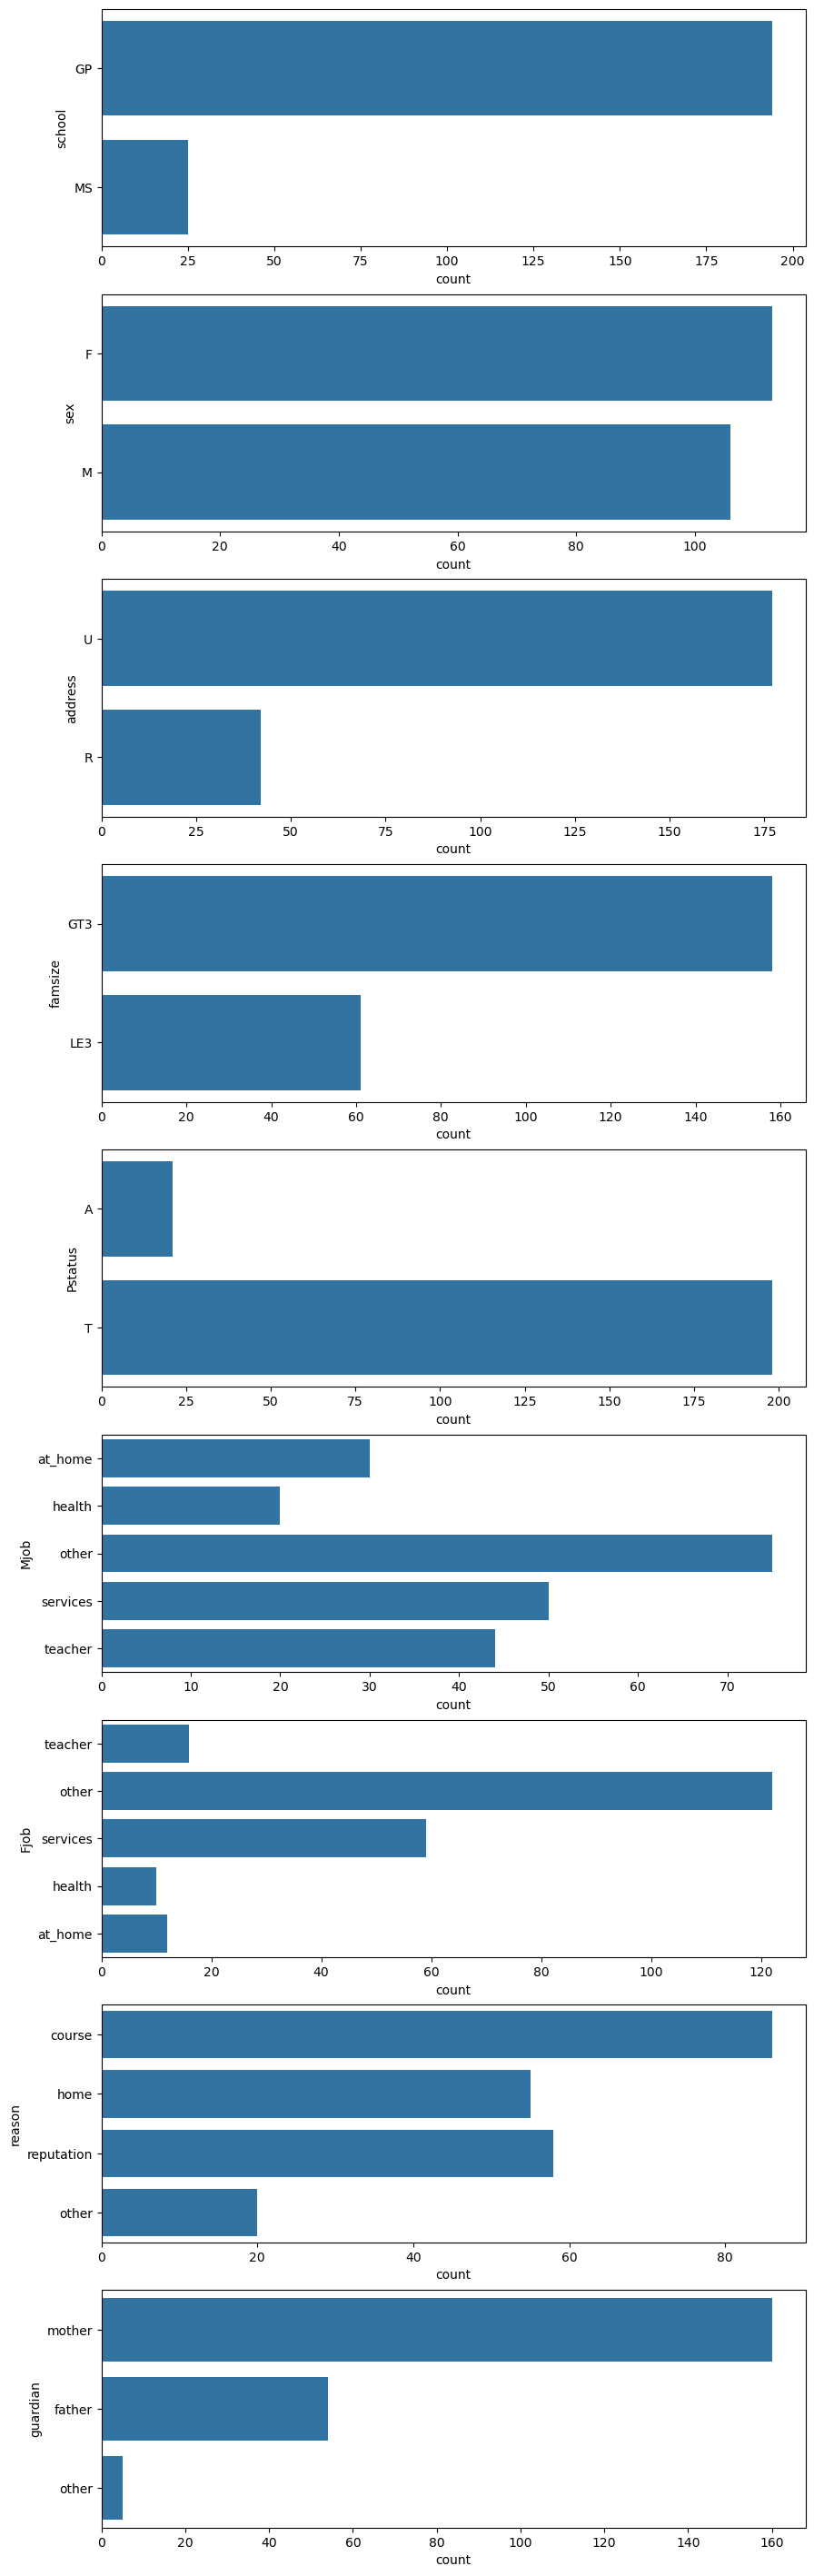

<Figure size 1200x800 with 0 Axes>

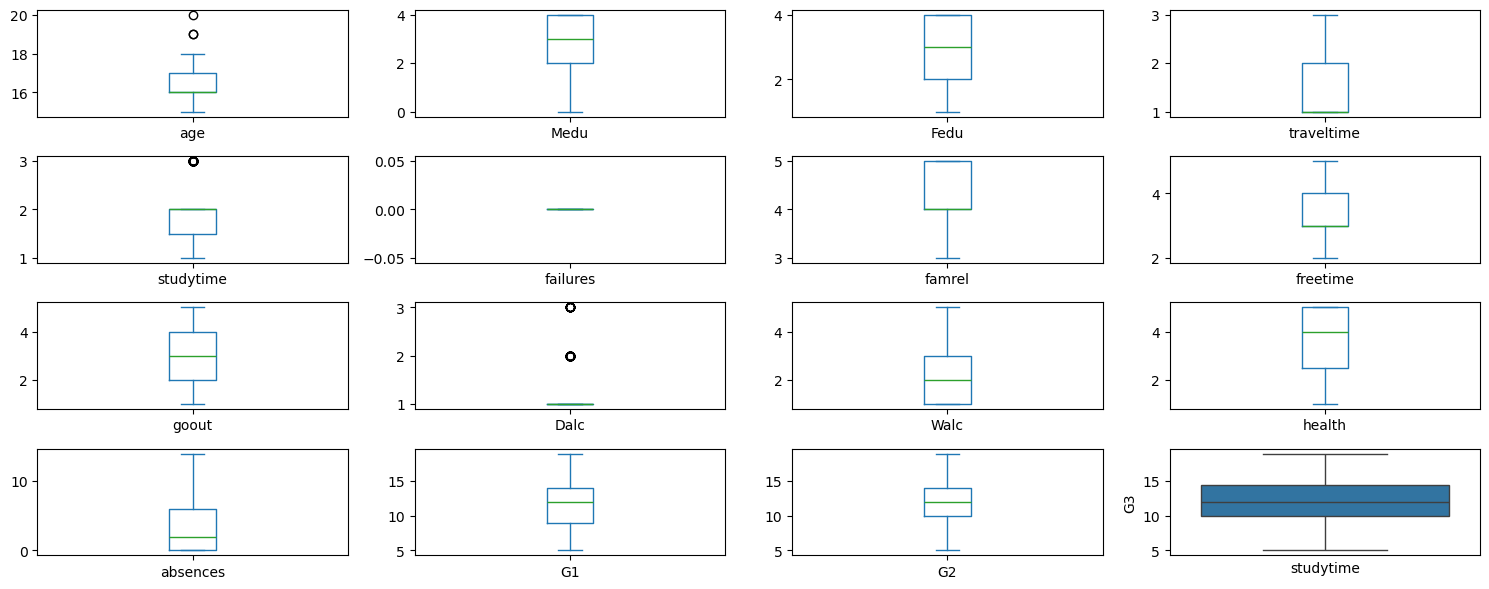

In [6]:
print(student_data.info())

print(student_data.describe())

num_cols = student_data.select_dtypes(include=['int64', 'float64']).columns

student_data[num_cols].hist(bins=15, figsize=(15, 10), layout=(4, 4))

cat_cols = student_data.select_dtypes(include=['object']).columns
fig, axes = plt.subplots(nrows=len(cat_cols), ncols=1, figsize=(10, len(cat_cols)*4))
for i, col in enumerate(cat_cols):
    sns.countplot(student_data[col], ax=axes[i])

plt.figure(figsize=(12, 8))

student_data[num_cols].plot(kind='box', subplots=True, layout=(4, 4), figsize=(15, 6))

print(student_data.isnull().sum())

sns.boxplot(x='studytime', y='G3', data=student_data)

plt.tight_layout()

plt.show()

In [8]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt

# Assuming you have the student_data DataFrame loaded
# Load your dataset here
# student_data = pd.read_csv('path_to_your_dataset.csv')

def analyze_grades(df, predictor, response):
    # One-Hot Encoding for the predictor
    predictor_dummies = pd.get_dummies(df[predictor], prefix=predictor)

    # Join the encoded df with the original df
    df_encoded = df.join(predictor_dummies)

    # Predictor and response variables
    X = df_encoded[predictor_dummies.columns]
    y = df_encoded[response]

    # Create and fit the linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Predictions
    y_pred = model.predict(X)

    # Calculate MSE and RMSE
    mse = mean_squared_error(y, y_pred)
    rmse = sqrt(mse)

    return mse, rmse

# Analyzing the relationship of 'studytime' with 'G1', 'G2', and 'G3'
results = {}
grades = ['G1', 'G2', 'G3']
for grade in grades:
    mse, rmse = analyze_grades(student_data, 'studytime', grade)
    results[grade] = {'MSE': mse, 'RMSE': rmse}

results


{'G1': {'MSE': 9.356539950759366, 'RMSE': 3.0588461796499944},
 'G2': {'MSE': 9.251331035914172, 'RMSE': 3.0416000782341803},
 'G3': {'MSE': 9.479909212579265, 'RMSE': 3.078946120441094}}

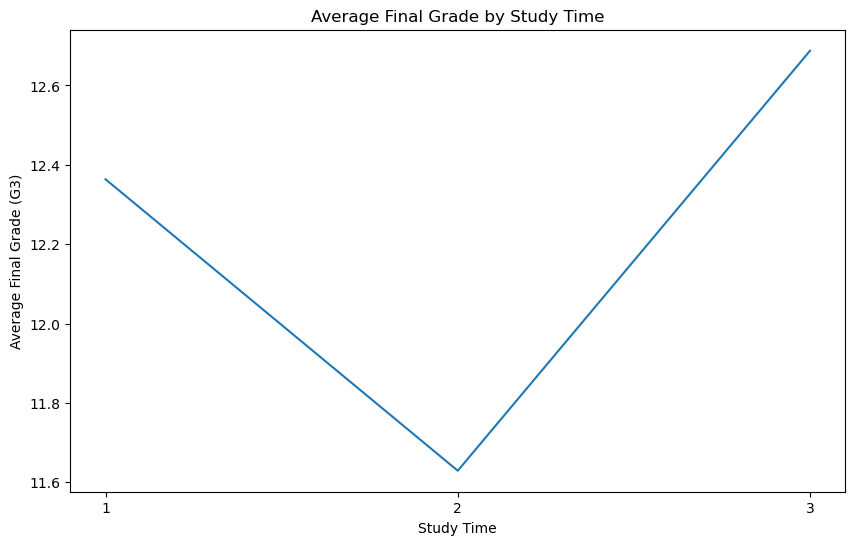

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset if not already loaded
# student_data = pd.read_csv('path_to_your_dataset.csv')

# Grouping data by 'studytime' and calculating the mean of 'G3' for each group
trend_data = student_data.groupby('studytime')['G3'].mean().reset_index()

# Visualization
plt.figure(figsize=(10, 6))
sns.lineplot(data=trend_data, x='studytime', y='G3')
plt.title('Average Final Grade by Study Time')
plt.xlabel('Study Time')
plt.ylabel('Average Final Grade (G3)')
plt.xticks(trend_data['studytime'])  # Ensure x-ticks represent study time categories
plt.show()


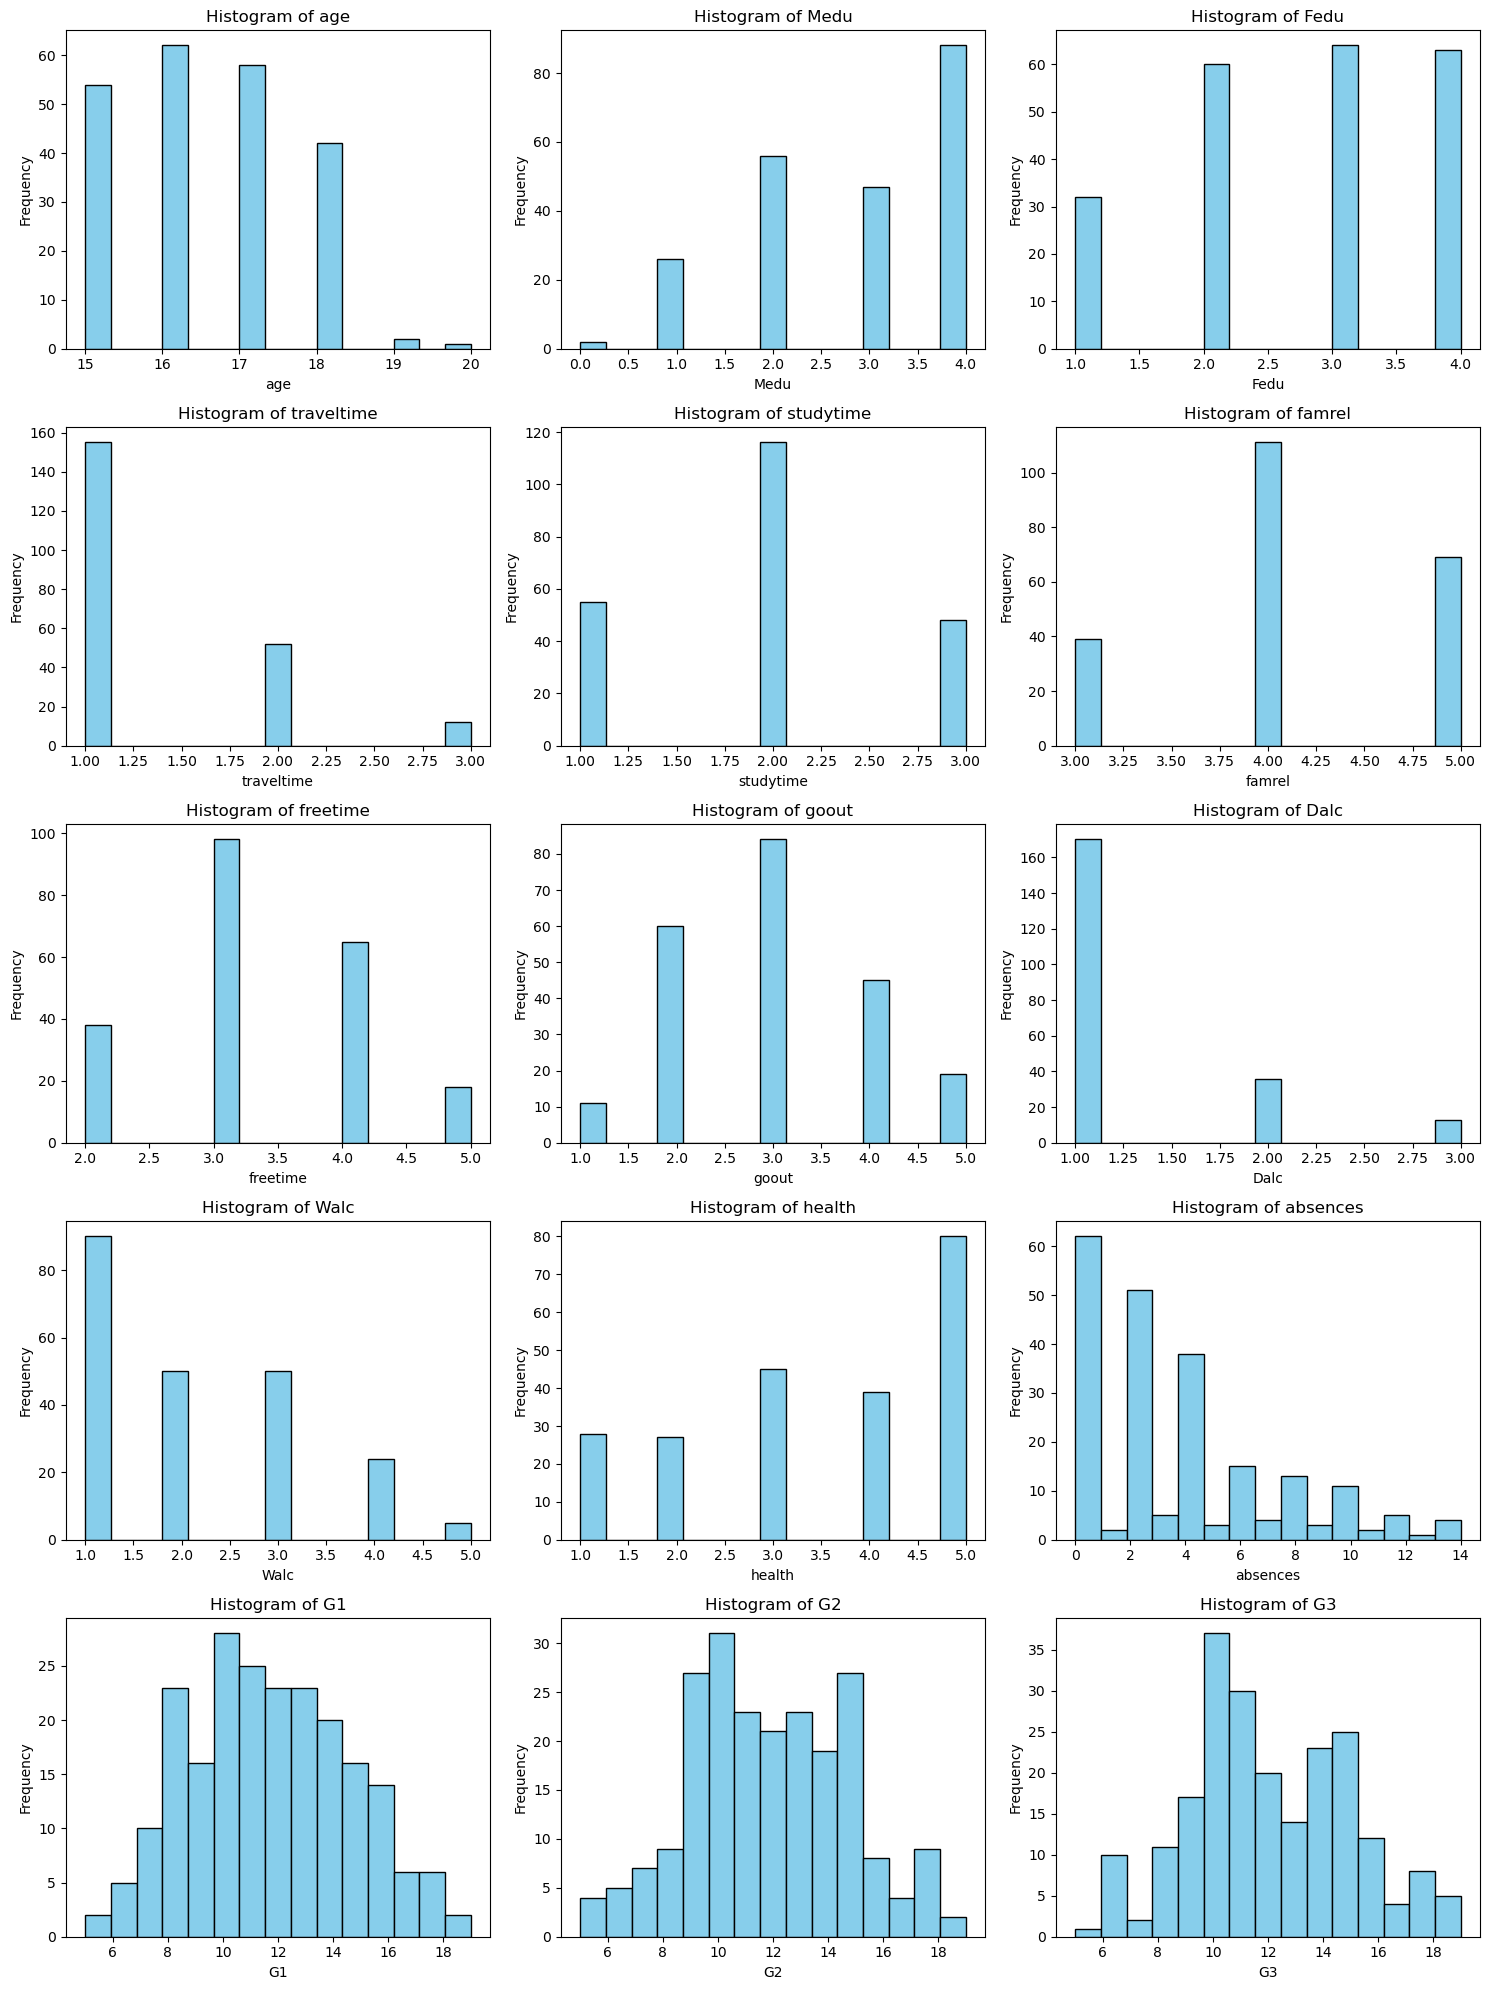

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have already loaded the student_data DataFrame
# If not, load it using pd.read_csv('path_to_your_data.csv')

# List of variables to plot histograms for
variables = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'famrel', 
             'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']

# Creating a figure and a grid of subplots
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 20))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Generate a histogram for each variable
for i, var in enumerate(variables):
    axes[i].hist(student_data[var], bins=15, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Histogram of {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frequency')

# Adjust the layout
plt.tight_layout()
plt.show()


<BarContainer object of 219 artists>

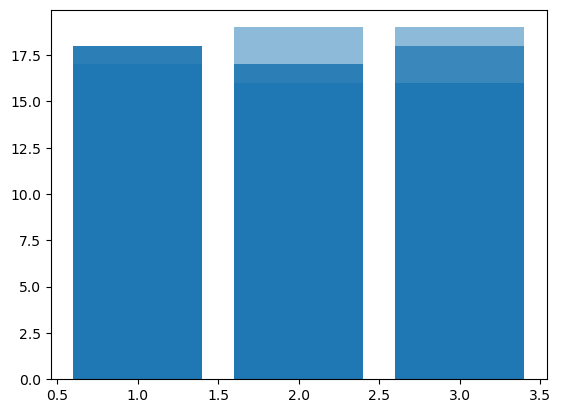

In [20]:
plt.bar(student_data['studytime'], student_data['G1'], align='center', alpha=0.5)

<BarContainer object of 219 artists>

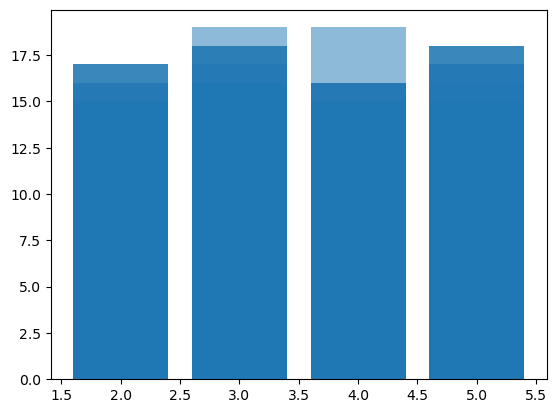

In [23]:
plt.bar(student_data['freetime'], student_data['G1'], align='center', alpha=0.5)

<BarContainer object of 219 artists>

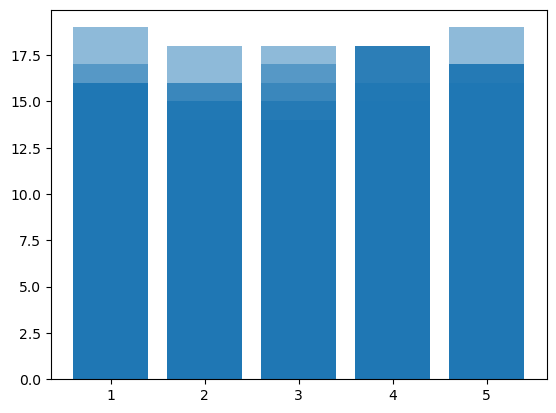

In [24]:
plt.bar(student_data['health'], student_data['G1'], align='center', alpha=0.5)

<BarContainer object of 219 artists>

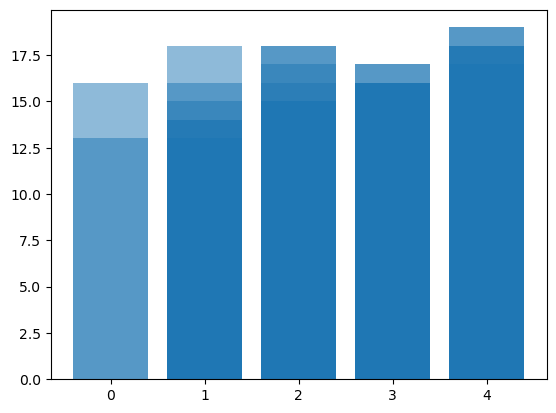

In [26]:
plt.bar(student_data['Medu'], student_data['G1'], align='center', alpha=0.5)

<BarContainer object of 219 artists>

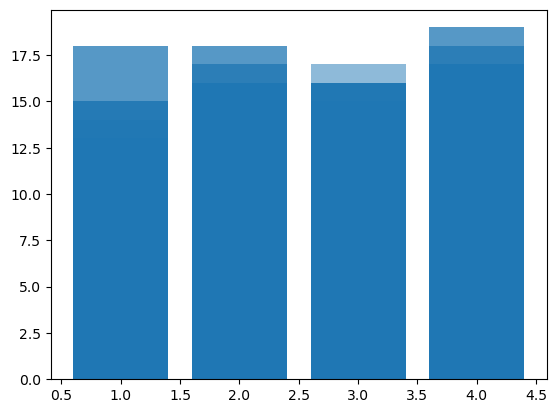

In [27]:
plt.bar(student_data['Fedu'], student_data['G1'], align='center', alpha=0.5)

<BarContainer object of 219 artists>

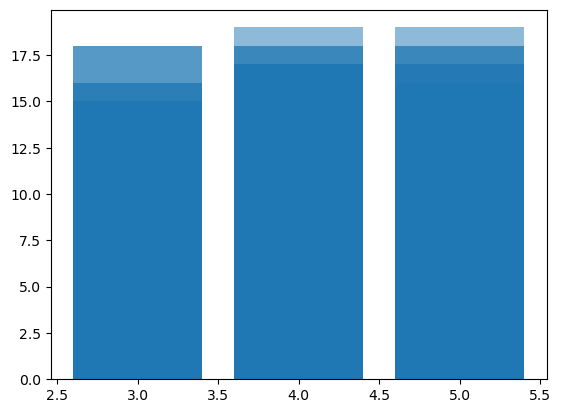

In [32]:
plt.bar(student_data['famrel'], student_data['G1'], align='center', alpha=0.5)

In [33]:
student_data

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10
5,GP,M,16,U,LE3,T,4,3,services,other,...,5,4,2,1,2,5,10,15,15,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,MS,F,18,R,GT3,T,2,2,at_home,other,...,5,3,3,1,3,4,2,10,9,10
386,MS,F,18,R,GT3,T,4,4,teacher,at_home,...,4,4,3,2,2,5,7,6,5,6
388,MS,F,18,U,LE3,T,3,1,teacher,services,...,4,3,4,1,1,1,0,7,9,8
393,MS,M,18,R,LE3,T,3,2,services,other,...,4,4,1,3,4,5,0,11,12,10


In [34]:
student_data

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10
5,GP,M,16,U,LE3,T,4,3,services,other,...,5,4,2,1,2,5,10,15,15,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,MS,F,18,R,GT3,T,2,2,at_home,other,...,5,3,3,1,3,4,2,10,9,10
386,MS,F,18,R,GT3,T,4,4,teacher,at_home,...,4,4,3,2,2,5,7,6,5,6
388,MS,F,18,U,LE3,T,3,1,teacher,services,...,4,3,4,1,1,1,0,7,9,8
393,MS,M,18,R,LE3,T,3,2,services,other,...,4,4,1,3,4,5,0,11,12,10


[Text(0.5, 1.0, 'Absences vs G1')]

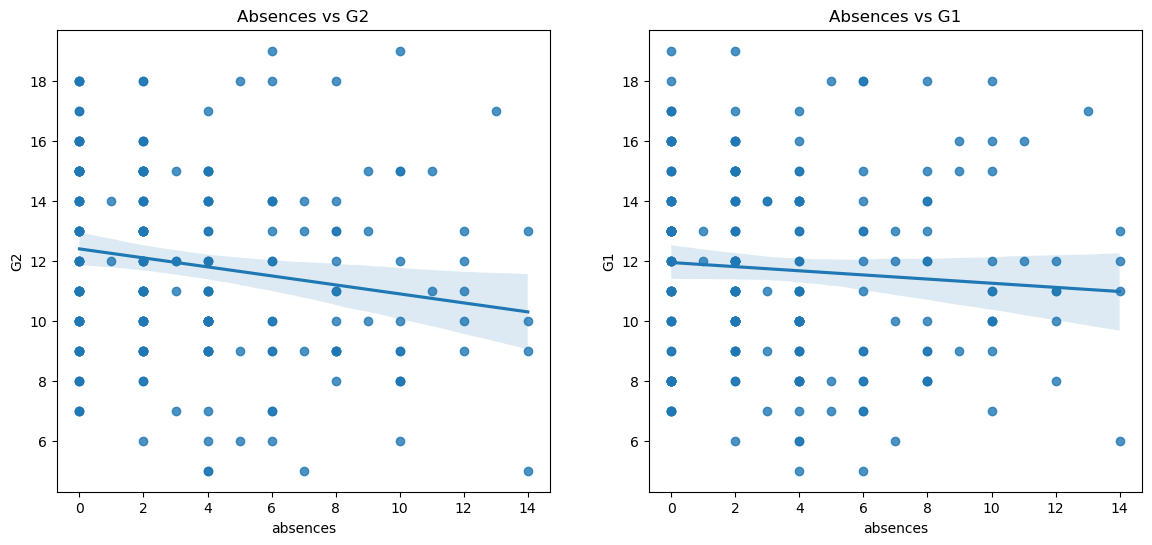

In [36]:
fig, axes = plt.subplots(1,2, figsize=(14,6))
sns.regplot(x='absences', y='G2', data=student_data, ax=axes[0])
axes[0].set(title='Absences vs G2')

sns.regplot(x='absences', y='G1', data=student_data, ax=axes[1])
axes[1].set(title='Absences vs G1')

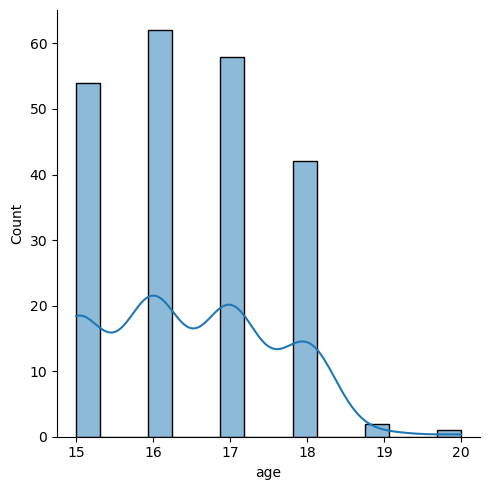

In [38]:
sns.displot(x='age', data=student_data, kind='hist', kde=True)

## Predictive Modelling

I used a bunch of different models to see which produced the best fit. Below is a brief explanation of each model:

Linear Regression: This is one of the simplest and most commonly used types of regression analysis. Linear regression attempts to model the relationship between two or more variables by fitting a linear equation to observed data. The main goal is to predict the value of a dependent variable based on the values of one or more independent variables.

Robust Regression: Robust regression is used in situations where the data contains outliers or is not normally distributed. Traditional regression techniques like linear regression are sensitive to outliers, which can significantly influence the results. Robust regression methods are designed to be less sensitive to outliers and can provide more reliable estimates in these situations.

Ridge Regression: Also known as Tikhonov regularization, Ridge Regression addresses some of the problems of Ordinary Least Squares (OLS) by imposing a penalty on the size of coefficients. This penalty term shrinks the coefficients and helps to reduce model complexity and prevent over-fitting, which may result from simple linear regression.

Lasso Regression: The Least Absolute Shrinkage and Selection Operator (LASSO) is a regression method that involves a penalty factor on the absolute size of the regression coefficients. Like Ridge Regression, Lasso also prevents over-fitting but can additionally set some coefficients to zero, effectively performing variable selection. This leads to models that are simpler and more interpretable.

Polynomial Regression: This is a form of regression analysis in which the relationship between the independent variable x and the dependent variable y is modeled as an nth-degree polynomial. Polynomial regression fits a nonlinear relationship between the value of x and the corresponding conditional mean of y.

Stochastic Gradient Descent (SGD): SGD is a simple yet very efficient approach to fitting linear classifiers and regressors under convex loss functions such as (linear) Support Vector Machines and Logistic Regression. It is particularly useful when the number of samples (and the number of features) is very large.

Random Forest Regressor: This is a type of ensemble learning method, where a group of weak models combine to form a powerful model. In Random Forest, multiple decision trees are constructed and the final prediction is made based on the average or majority voting principle of individual trees. It's known for its high accuracy, ability to run in parallel, and handling of unbalanced and missing data.

SVM Regressor (Support Vector Machine Regressor): SVM can be used for both classification and regression challenges. However, it is mostly used in classification problems. In the SVM algorithm, we plot each data item as a point in n-dimensional space (where n is the number of features you have) with the value of each feature being the value of a particular coordinate. The SVM then finds a hyper-plane that best separates the classes.

In [68]:
new_df = pd.get_dummies(student_data, columns=['school','sex','address','famsize','Pstatus','Mjob','Fjob','reason','guardian','schoolsup','famsup','paid','activities','nursery','higher','internet',
 'romantic'])

In [40]:
new_df.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_False,activities_True,nursery_False,nursery_True,higher_False,higher_True,internet_False,internet_True,romantic_False,romantic_True
0,18,4,4,2,2,0,4,3,4,1,...,True,False,False,True,False,True,True,False,True,False
1,17,1,1,1,2,0,5,3,3,1,...,True,False,True,False,False,True,False,True,True,False
3,15,4,2,1,3,0,3,2,2,1,...,False,True,False,True,False,True,False,True,False,True
4,16,3,3,1,2,0,4,3,2,1,...,True,False,False,True,False,True,True,False,True,False
5,16,4,3,1,2,0,5,4,2,1,...,False,True,False,True,False,True,False,True,True,False


In [41]:
X = new_df.drop('G3', axis=1).values
y = new_df['G3'].values

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((153, 58), (153,), (66, 58), (66,))

In [45]:
# Scaling the data using pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('std_scalar', StandardScaler())
])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)
X_test

array([[ 1.35523748,  1.00574596, -0.73076923, ...,  0.42062225,
        -1.70970083,  1.70970083],
       [ 0.48033733, -1.6626783 ,  0.25      , ...,  0.42062225,
         0.58489765, -0.58489765],
       [ 1.35523748,  0.11627121, -1.71153846, ...,  0.42062225,
         0.58489765, -0.58489765],
       ...,
       [-0.39456281, -0.77320354, -0.73076923, ..., -2.37743011,
         0.58489765, -0.58489765],
       [-0.39456281, -0.77320354,  0.25      , ...,  0.42062225,
         0.58489765, -0.58489765],
       [ 0.48033733,  0.11627121, -1.71153846, ...,  0.42062225,
        -1.70970083,  1.70970083]])

In [46]:
# initializing the algorithm
lin_reg = LinearRegression()

# Fitting Simple Linear Regression to the Training set
lin_reg.fit(X_train,y_train)

LinearRegression()

In [47]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X, y, cv=10)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [48]:
test_pred = lin_reg.predict(X_test)
train_pred = lin_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 0.6390870549945855
MSE: 0.6810493685772306
RMSE: 0.8252571529997366
R2 Square 0.9387004907529048
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.5347046844609581
MSE: 0.48765049186539416
RMSE: 0.6983197633358189
R2 Square 0.9456367610671431
__________________________________


In [49]:
results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y_test, test_pred) , cross_val(LinearRegression())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,0.639087,0.681049,0.825257,0.9387,0.903795


In [50]:
from sklearn.linear_model import RANSACRegressor

model = RANSACRegressor( max_trials=100)
model.fit(X_train, y_train)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 0.687246455736739
MSE: 0.8763133991559076
RMSE: 0.9361161248242162
R2 Square 0.9211252755036959
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.5693418669164699
MSE: 0.5611244159033945
RMSE: 0.7490823825877861
R2 Square 0.9374458937257955
__________________________________


In [51]:
results_df_2 = pd.DataFrame(data=[["Robust Regression", *evaluate(y_test, test_pred) , cross_val(RANSACRegressor())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = pd.merge(results_df , results_df_2 , how='outer')

In [52]:
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,0.639087,0.681049,0.825257,0.938700,0.903795
1,Robust Regression,0.687246,0.876313,0.936116,0.921125,0.896966


In [53]:
from sklearn.linear_model import Ridge

model = Ridge(alpha=100, solver='cholesky', tol=0.0001, random_state=42)
model.fit(X_train, y_train)
pred = model.predict(X_test)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 1.1033128514009256
MSE: 1.8342969514791219
RMSE: 1.3543621936096422
R2 Square 0.8348996297081772
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.8932078377756588
MSE: 1.2101811822362818
RMSE: 1.1000823524792505
R2 Square 0.8650890958598316
__________________________________


In [54]:
results_df_3 = pd.DataFrame(data=[["Ridge Regression", *evaluate(y_test, test_pred) , cross_val(Ridge())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])

results_df = pd.merge(results_df , results_df_3 , how='outer')

In [55]:
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,0.639087,0.681049,0.825257,0.938700,0.903795
1,Robust Regression,0.687246,0.876313,0.936116,0.921125,0.896966
2,Ridge Regression,1.103313,1.834297,1.354362,0.834900,0.905758


In [56]:
from sklearn.linear_model import Lasso

model = Lasso(alpha=0.1, 
              precompute=True, 
#               warm_start=True, 
              positive=True, 
              selection='random',
              random_state=42)
model.fit(X_train, y_train)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 0.634785034585078
MSE: 0.655213871603105
RMSE: 0.8094528223455058
R2 Square 0.9410258776613124
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.581130203910197
MSE: 0.6235469138949477
RMSE: 0.7896498679129552
R2 Square 0.9304870385011866
__________________________________


In [57]:
results_df_4 = pd.DataFrame(data=[["Lasso Regression", *evaluate(y_test, test_pred) , cross_val(Lasso())]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df = pd.merge(results_df , results_df_4 , how='outer')
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,0.639087,0.681049,0.825257,0.938700,0.903795
1,Robust Regression,0.687246,0.876313,0.936116,0.921125,0.896966
2,Ridge Regression,1.103313,1.834297,1.354362,0.834900,0.905758
3,Lasso Regression,0.634785,0.655214,0.809453,0.941026,0.912411


In [58]:
from sklearn.preprocessing import PolynomialFeatures

poly_reg = PolynomialFeatures(degree=2)

X_train_2_d = poly_reg.fit_transform(X_train)
X_test_2_d = poly_reg.transform(X_test)

lin_reg = LinearRegression()
lin_reg.fit(X_train_2_d,y_train)

test_pred = lin_reg.predict(X_test_2_d)
train_pred = lin_reg.predict(X_train_2_d)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 2.130847058393038
MSE: 7.093033803162428
RMSE: 2.663275014556782
R2 Square 0.36157419525217915
__________________________________
Train set evaluation:
_____________________________________
MAE: 6.571359288238835e-15
MSE: 7.285362477629345e-29
RMSE: 8.535433484966855e-15
R2 Square 1.0
__________________________________


In [59]:
results_df_5 = pd.DataFrame(data=[["Polynomail Regression", *evaluate(y_test, test_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
results_df = pd.merge(results_df , results_df_5 , how='outer')
results_df

/var/folders/pl/vyn8k19d03z4zxkkm9xgfj6r0000gn/T/ipykernel_74173/3181958154.py:3: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  results_df = pd.merge(results_df , results_df_5 , how='outer')


,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,0.639087,0.681049,0.825257,0.938700,0.903795
1,Robust Regression,0.687246,0.876313,0.936116,0.921125,0.896966
2,Ridge Regression,1.103313,1.834297,1.354362,0.834900,0.905758
3,Lasso Regression,0.634785,0.655214,0.809453,0.941026,0.912411
4,Polynomail Regression,2.130847,7.093034,2.663275,0.361574,0.000000


In [60]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(n_iter_no_change=250, penalty=None, eta0=0.0001, max_iter=100000)
sgd_reg.fit(X_train, y_train)

test_pred = sgd_reg.predict(X_test)
train_pred = sgd_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 1.148919025945598
MSE: 1.9034805234653092
RMSE: 1.37966681610645
R2 Square 0.8286725935983369
__________________________________
Train set evaluation:
_____________________________________
MAE: 1.1920914209544156
MSE: 1.904195651099231
RMSE: 1.3799259585569188
R2 Square 0.7877204168099383
__________________________________


In [61]:
results_df_6 = pd.DataFrame(data=[["Stochastic Gradient Descent", *evaluate(y_test, test_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
results_df = pd.merge(results_df , results_df_6 , how='outer')
results_df

/var/folders/pl/vyn8k19d03z4zxkkm9xgfj6r0000gn/T/ipykernel_74173/1959038950.py:3: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  results_df = pd.merge(results_df , results_df_6 , how='outer')


,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,0.639087,0.681049,0.825257,0.938700,0.903795
1,Robust Regression,0.687246,0.876313,0.936116,0.921125,0.896966
2,Ridge Regression,1.103313,1.834297,1.354362,0.834900,0.905758
3,Lasso Regression,0.634785,0.655214,0.809453,0.941026,0.912411
4,Polynomail Regression,2.130847,7.093034,2.663275,0.361574,0.000000
5,Stochastic Gradient Descent,1.148919,1.903481,1.379667,0.828673,0.000000


In [62]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=1000)
rf_reg.fit(X_train, y_train)

test_pred = rf_reg.predict(X_test)
train_pred = rf_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_6 = pd.DataFrame(data=[["Random Forest Regressor", *evaluate(y_test, test_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])

Test set evaluation:
_____________________________________
MAE: 0.6733484848484849
MSE: 0.7462804696969697
RMSE: 0.863875262811113
R2 Square 0.9328292064220184
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.25520915032679736
MSE: 0.11189258169934639
RMSE: 0.3345034853321358
R2 Square 0.9875262236884715
__________________________________


In [63]:
results_df = pd.merge(results_df , results_df_6 , how='outer')
results_df

/var/folders/pl/vyn8k19d03z4zxkkm9xgfj6r0000gn/T/ipykernel_74173/1856174570.py:1: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  results_df = pd.merge(results_df , results_df_6 , how='outer')


,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,0.639087,0.681049,0.825257,0.938700,0.903795
1,Robust Regression,0.687246,0.876313,0.936116,0.921125,0.896966
2,Ridge Regression,1.103313,1.834297,1.354362,0.834900,0.905758
3,Lasso Regression,0.634785,0.655214,0.809453,0.941026,0.912411
4,Polynomail Regression,2.130847,7.093034,2.663275,0.361574,0.000000
5,Stochastic Gradient Descent,1.148919,1.903481,1.379667,0.828673,0.000000
6,Random Forest Regressor,0.673348,0.746280,0.863875,0.932829,0.000000


In [64]:
from sklearn.svm import SVR

svm_reg = SVR(kernel='rbf', C=1000000, epsilon=0.001)
svm_reg.fit(X_train, y_train)

test_pred = svm_reg.predict(X_test)
train_pred = svm_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

results_df_7 = pd.DataFrame(data=[["SVM Regressor", *evaluate(y_test, test_pred), 0]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])

Test set evaluation:
_____________________________________
MAE: 1.194843455246762
MSE: 2.2700483571346024
RMSE: 1.5066679651252304
R2 Square 0.7956787618051424
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.001051378869628356
MSE: 1.1438331504506907e-06
RMSE: 0.001069501355983568
R2 Square 0.9999998724855693
__________________________________


In [65]:
results_df = pd.merge(results_df , results_df_7 , how='outer')
results_df

/var/folders/pl/vyn8k19d03z4zxkkm9xgfj6r0000gn/T/ipykernel_74173/2738876734.py:1: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  results_df = pd.merge(results_df , results_df_7 , how='outer')


,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,0.639087,0.681049,0.825257,0.938700,0.903795
1,Robust Regression,0.687246,0.876313,0.936116,0.921125,0.896966
2,Ridge Regression,1.103313,1.834297,1.354362,0.834900,0.905758
3,Lasso Regression,0.634785,0.655214,0.809453,0.941026,0.912411
4,Polynomail Regression,2.130847,7.093034,2.663275,0.361574,0.000000
5,Stochastic Gradient Descent,1.148919,1.903481,1.379667,0.828673,0.000000
6,Random Forest Regressor,0.673348,0.746280,0.863875,0.932829,0.000000
7,SVM Regressor,1.194843,2.270048,1.506668,0.795679,0.000000


Text(0.5, 0, 'R2')

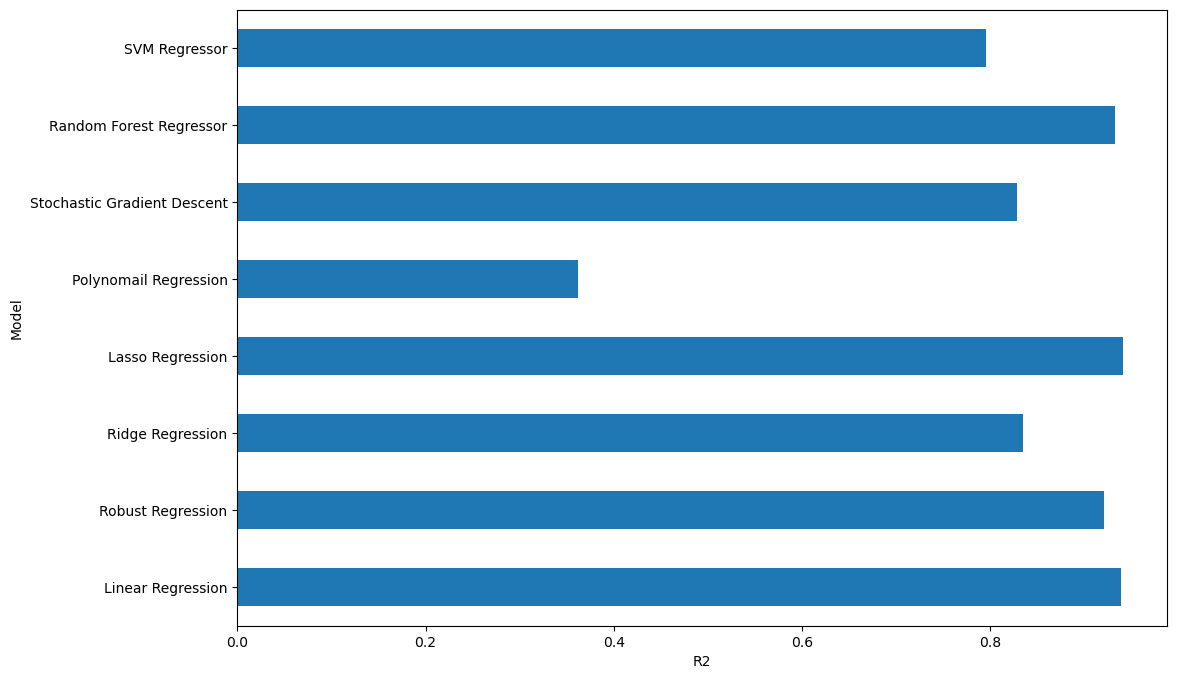

In [66]:
results_df.set_index('Model', inplace=True)
results_df['R2 Square'].plot(kind='barh', figsize=(12, 8))
plt.xlabel('R2')

In [67]:
X = new_df.drop('G3', axis=1)
y = new_df['G3']
X

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_False,activities_True,nursery_False,nursery_True,higher_False,higher_True,internet_False,internet_True,romantic_False,romantic_True
0,18,4,4,2,2,0,4,3,4,1,...,True,False,False,True,False,True,True,False,True,False
1,17,1,1,1,2,0,5,3,3,1,...,True,False,True,False,False,True,False,True,True,False
3,15,4,2,1,3,0,3,2,2,1,...,False,True,False,True,False,True,False,True,False,True
4,16,3,3,1,2,0,4,3,2,1,...,True,False,False,True,False,True,True,False,True,False
5,16,4,3,1,2,0,5,4,2,1,...,False,True,False,True,False,True,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,18,2,2,2,3,0,5,3,3,1,...,True,False,False,True,False,True,True,False,True,False
386,18,4,4,3,1,0,4,4,3,2,...,False,True,False,True,False,True,False,True,False,True
388,18,3,1,1,2,0,4,3,4,1,...,True,False,False,True,False,True,False,True,True,False
393,18,3,2,3,1,0,4,4,1,3,...,True,False,True,False,False,True,False,True,True,False
